#### 참고 : tensorflow.keras 공식 문서 (Official API Docs) @ https://www.tensorflow.org/api_docs/python/tf/keras

<br>

## 1. Data loading & preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
del titanic_df['Cabin'] # 너무 많은 결측치가 존재
del titanic_df['PassengerId'] # Passenger 번호는 큰 의미를 갖고있지 않은 일련번호
del titanic_df['Ticket'] # ticket 번호에서 패턴이 확인되지 않음


titanic_df['Title'] = titanic_df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
del titanic_df['Name'] # 호칭만 남김

rare_title = []
for title in set(titanic_df['Title']):
    if list(titanic_df['Title']).count(title) < 10:
        rare_title.append(title)

titanic_df['Title'] = titanic_df['Title'].replace('Mlle', 'Miss') # Mademoiselle
titanic_df['Title'] = titanic_df['Title'].replace('Ms', 'Miss') 
titanic_df['Title'] = titanic_df['Title'].replace('Mme', 'Mrs') # Madame
titanic_df['Title'] = titanic_df['Title'].replace(rare_title, 'Rare')

title_mapping = {"Master":1, "Miss":2, "Mr":3, "Mrs":4, "Rare":5 }
titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna(0)
titanic_df['Title'].astype(int)


sex_mapping = {"male": 0 , "female":1} 
titanic_df['Sex'] = titanic_df['Sex'].map(sex_mapping)


titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')
mapping_data ={"S":0, "Q":1, "C":2}
titanic_df["Embarked"] = titanic_df["Embarked"].map(mapping_data)


titanic_df.loc[ titanic_df['Fare'] <= 102, 'Fare'] = 0
titanic_df.loc[(titanic_df['Fare'] > 102) & (titanic_df['Fare'] <= 204), 'Fare'] = 1
titanic_df.loc[(titanic_df['Fare'] > 204) & (titanic_df['Fare'] <= 307), 'Fare'] = 2
titanic_df.loc[ titanic_df['Fare'] > 307, 'Fare'] = 4


titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] +1
del titanic_df['SibSp']
del titanic_df['Parch']

titanic_df['isAlone'] = 0
titanic_df.loc[titanic_df['FamilySize'] == 1, 'isAlone'] = 1

family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10: 3.6, 11: 4}
titanic_df['FamilySize'] = titanic_df['FamilySize'].map(family_mapping)


titanic_df["Age"].fillna(titanic_df.groupby("Title")["Age"].transform("median"), inplace=True)

titanic_df.loc[ titanic_df['Age'] <= 16, 'Age'] = 0
titanic_df.loc[(titanic_df['Age'] > 16) & (titanic_df['Age'] <= 32), 'Age'] = 1
titanic_df.loc[(titanic_df['Age'] > 32) & (titanic_df['Age'] <= 48), 'Age'] = 2
titanic_df.loc[(titanic_df['Age'] > 48) & (titanic_df['Age'] <= 64), 'Age'] = 3
titanic_df.loc[ titanic_df['Age'] > 64, 'Age'] = 4

titanic_df.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize,isAlone
0,0,3,0,1.0,0.0,0,3,0.4,0
1,1,1,1,2.0,0.0,2,4,0.4,0
2,1,3,1,1.0,0.0,0,2,0.0,1


<br>

## 2. Devide dataframe into X & Y -> Train X / Test X / Train Y / Test Y

In [4]:
titanic_target = titanic_df[['Survived']].copy()
titanic_data = titanic_df.copy()

del titanic_data['Survived']

In [5]:
from sklearn import model_selection

In [9]:
train_data, test_data, train_label, test_label = model_selection.?(titanic_data, titanic_target,
                                                                                 test_size=0.3,
                                                                                 random_state=0)
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(623, 8)
(268, 8)
(623, 1)
(268, 1)


<br>

## 3. Change normal labels to one-hot labels

In [17]:
train_label[:5]

In [ ]:
from tensorflow.keras import utils

train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

print(train_label.?) # 모양을 영어로?
print(test_label.?) # 모양을 영어로?

# from sklearn import preprocessing
# enc = preprocessing.OneHotEncoder(categories='auto') # Apply 'One-hot encoding' on labels (Single integer to One-hot vector)
# train_label = enc.fit_transform(train_label).toarray()
# test_label = enc.fit_transform(test_label).toarray()

In [20]:
train_label

<br>

## 4. Build & Train the model 

In [21]:
import tensorflow as tf

# tf.keras 에 필요한 함수들이 모여있습니다.
from tensorflow.? import datasets, utils
from tensorflow.? import models, layers, activations, initializers, losses, optimizers, metrics

In [22]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information

In [35]:
model = models.?() # Build up the "Sequence" of layers (Linear stack of layers)

# Dense-layer (with he-initialization)
model.add(layers.?(input_dim=?, units=256, activation=None, kernel_initializer=initializers.?())) # he-uniform initialization
# model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('?')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.?(units=512, activation=None, kernel_initializer=initializers.?())) 
model.add(layers.Activation('?')) 

model.add(layers.?(units=512, activation=None, kernel_initializer=initializers.?())) 
model.add(layers.Activation('?'))

model.add(layers.?(units=256, activation=None, kernel_initializer=initializers.?())) 
model.add(layers.Activation('?')) 
model.add(layers.Dropout(rate=0.5)) # Dropout-layer

model.add(layers.Dense(units=?, activation='?')) # Apply softmax function on model's output

In [36]:
# "Compile" the model description (Configures the model for training)

model.compile(optimizer=optimizers.?(), # Please try the Adam-optimizer
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) # Precision / Recall / F1-Score 적용하기 @ https://j.mp/3cf3lbi

In [37]:
# "Fit" the model on training data

history = model.?(train_data, train_label, batch_size=100, epochs=20, validation_split=0.3) 

Train on 436 samples, validate on 187 samples
Epoch 1/20
436/436 [==============================] - 1s 2ms/sample - loss: 1.6125 - categorical_accuracy: 0.6353 - val_loss: 1.1402 - val_categorical_accuracy: 0.7059
Epoch 2/20
436/436 [==============================] - 0s 165us/sample - loss: 1.1135 - categorical_accuracy: 0.7362 - val_loss: 0.4862 - val_categorical_accuracy: 0.8075
Epoch 3/20
436/436 [==============================] - 0s 186us/sample - loss: 0.8148 - categorical_accuracy: 0.7248 - val_loss: 0.5454 - val_categorical_accuracy: 0.7968
Epoch 4/20
436/436 [==============================] - 0s 200us/sample - loss: 0.6337 - categorical_accuracy: 0.7729 - val_loss: 0.6168 - val_categorical_accuracy: 0.7219
Epoch 5/20
436/436 [==============================] - 0s 193us/sample - loss: 0.6596 - categorical_accuracy: 0.7638 - val_loss: 0.4823 - val_categorical_accuracy: 0.8342
Epoch 6/20
436/436 [==============================] - 0s 216us/sample - loss: 0.6401 - categorical_accurac

In [3]:
# "Evaluate" the model on test data

result = model.?(test_data, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

In [39]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

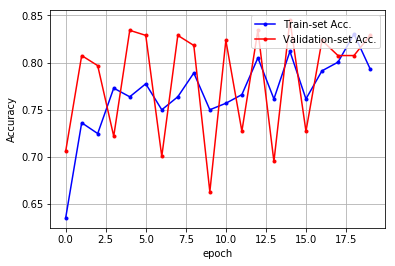

In [40]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

In [39]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

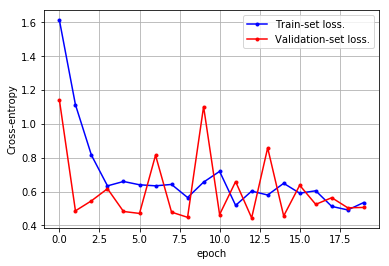

In [41]:
loss = history.history['?']
val_loss = history.history['?']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

In [ ]:
# 'Predict' on test data

model.predict(test_data)

In [42]:
np.argmax(model.predict(test_data), axis=1)

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0], dtype=int64)

In [45]:
sample_data = np.array([[3, 0, 0.0, 0.0, 1, 1, 2.0, 0]])

In [46]:
model.predict(sample_data)

array([[0.99734   , 0.00265993]], dtype=float32)

In [47]:
np.argmax(model.predict(sample_data), axis=1)

array([0], dtype=int64)